# Partial Differential Equations solved using PINNs.
- Solving dQ_dt + v * dQ_dx = 0
- IC : Q(x, t=0) = sin(k * X)
- BC : Q(x=0, t) = Q(x=L, t)

### 0. Defining a few functions and initial, boundaries, eqns and stuff.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import torch
import torch.nn as nn

### 1. Defining the initial arrays of space and time.

In [ ]:
L = 6.0 #[m]
T_final = 1.0 #[s]

Nx = 50
Nt = 50

k = ( 2 * np.pi ) / L

x = torch.linspace(0, L, Nx).view(-1, 1)  #[Nx]
t = torch.linspace(0, T_final, Nt).view(-1, 1) #[Nt]

print(f"Shape of x : {x.shape} and t : {t.shape}")

Shape of x : torch.Size([50, 1]) and t : torch.Size([50, 1])


In [ ]:
# Meshes and vectors
X_train, t_train = torch.meshgrid(x.squeeze() ,t.squeeze(), indexing='xy')

X_train, t_train = X_train.reshape(-1, 1), t_train.reshape(-1, 1)

print(f"Shape of X_train : {X_train.shape} and t_train : {t_train.shape}")

Shape of X_train : torch.Size([2500, 1]) and t_train : torch.Size([2500, 1])


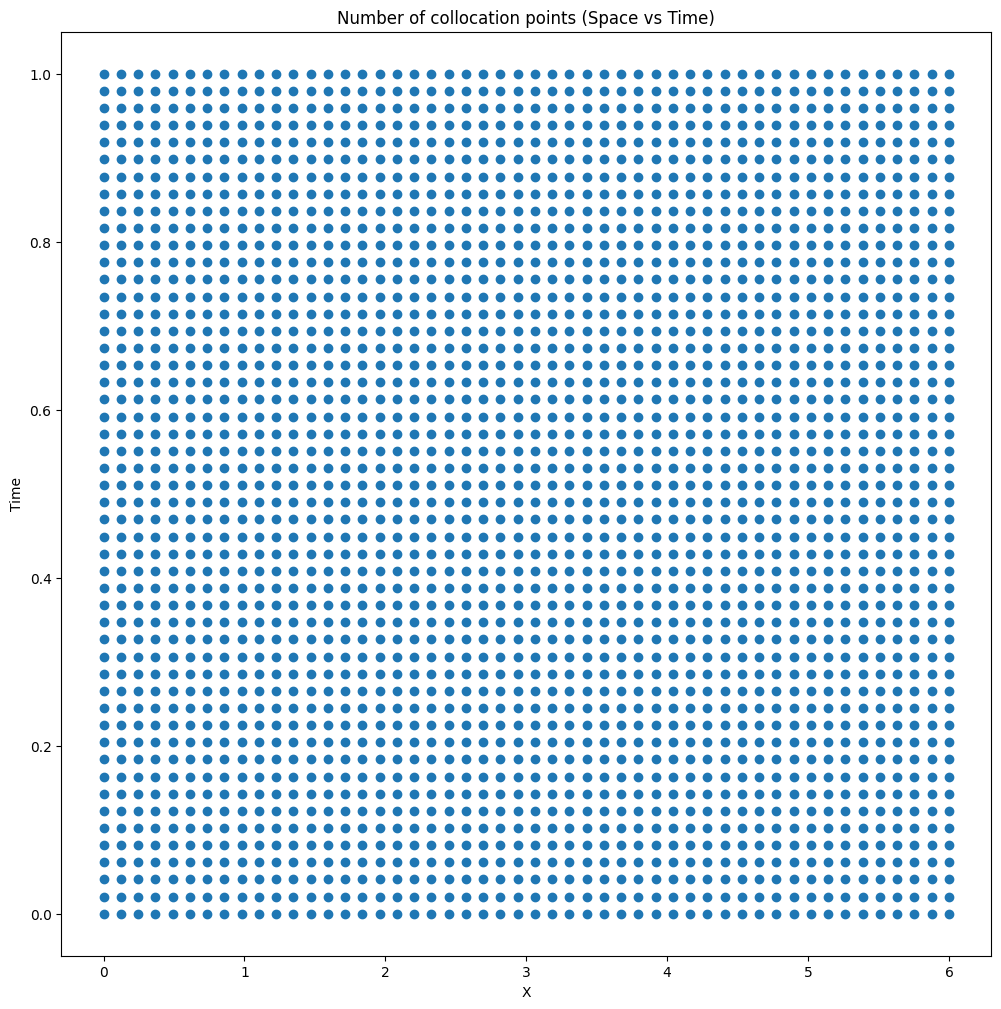

In [ ]:
plt.figure(figsize=(12,12))

plt.scatter(X_train, t_train)
plt.xlabel("X")
plt.ylabel("Time")
plt.title("Number of collocation points (Space vs Time)")
plt.show()

### 2. Neural network architecture.

In [ ]:
class PINN(nn.Module):
  def __init__(self, N_INPUT, N_HIDDEN, N_LAYERS, N_OUTPUT):
    super().__init__()
    activation = nn.SiLU

    layers = [nn.Linear(N_INPUT, N_HIDDEN), activation()] #initialy contains just the 1 layer

    for _ in range(N_LAYERS-1):
      layers.append(nn.Linear(N_HIDDEN, N_HIDDEN)) #adding n-1 layers and n-1 activation functions as well.
      layers.append(activation())

    layers.append(nn.Linear(N_HIDDEN, N_OUTPUT)) #final output layer

    self.net = nn.Sequential(*layers) #unpacking all contents of layers into sequential.

  def forward(self, x, t):
    inputs = torch.cat([x, t], dim=1)
    q = self.net(inputs)
    return q

### 3. Now defining the losses :
- The P.D.E loss
- The initial condition loss
- The boundary condition loss

In [ ]:
def pde_loss(q_pred, x_train, t_train, v=1.0):
  """
  Eqn : dQ_dt + v * dQ_dx = 0 [Okay we did this]

  IC : Q(x, t=0) = sin(pi * x)
  BC : Q(x=-1, t) = Q(x=1, t) = 0  #Periodic Boundaries

  Finds physics loss based on the above equation.
  """
  dQ_dt = torch.autograd.grad(q_pred, t_train, torch.ones_like(q_pred), create_graph=True)[0]
  dQ_dx = torch.autograd.grad(q_pred, x_train, torch.ones_like(q_pred), create_graph=True)[0]

  eqn = dQ_dt + (v * dQ_dx)

  return torch.mean(eqn**2)


def initial_condition_loss(q_pred, x, t):
  initial_condition = torch.sin(k * x)

  return torch.mean((q_pred-initial_condition) ** 2)


def boundary_condition_loss(qlb_pred, qup_pred, t):

  return torch.mean((qup_pred - qlb_pred) ** 2) # Periodic along x axis


### 4. Writing the training loop.

In [ ]:
model = PINN(2, 64, 4, 1)
optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)
epochs = 500

In [ ]:
X_train.requires_grad = True
t_train.requires_grad = True


In [ ]:
TOTAL_LOSS = []

for epoch in range(1, epochs+1):
  model.train()
  optimiser.zero_grad()

  # Initial Condition
  q_pred_init = model(x, torch.zeros_like(x)) # q(x, t=0)
  ic_loss = initial_condition_loss(q_pred_init, x, torch.zeros_like(x))

  # Boundary Condition
  q_lb_pred = model(torch.full_like(t, -1), t) # q(x = -1, t)
  q_ub_pred = model(torch.full_like(t, 1),  t) # q(x = 1, t)
  bc_loss = boundary_condition_loss(q_lb_pred, q_ub_pred, t)

  # Physics Condition
  q_pred = model(X_train, t_train)
  physics_loss = pde_loss(q_pred, X_train , t_train, v=1.0)

  total_loss = physics_loss + ic_loss + bc_loss
  TOTAL_LOSS.append(total_loss.item())

  total_loss.backward()
  optimiser.step()

  if(epoch%1==0):
    print(f"[{epoch}/{epochs}] Losses - Total:{total_loss.item():.6f}, Physics:{physics_loss.item():.6f}, IC:{ic_loss.item():.4f}, BC:{bc_loss.item():.6f}")

[1/500] Losses - Total:0.499422, Physics:0.000005, IC:0.4994, BC:0.000040
[2/500] Losses - Total:0.412918, Physics:0.012763, IC:0.3911, BC:0.009061
[3/500] Losses - Total:0.361951, Physics:0.008679, IC:0.3525, BC:0.000750
[4/500] Losses - Total:0.340324, Physics:0.031842, IC:0.3082, BC:0.000276
[5/500] Losses - Total:0.460590, Physics:0.002796, IC:0.4229, BC:0.034877
[6/500] Losses - Total:0.285806, Physics:0.005306, IC:0.2722, BC:0.008318
[7/500] Losses - Total:0.271085, Physics:0.015839, IC:0.2549, BC:0.000313
[8/500] Losses - Total:0.267436, Physics:0.014781, IC:0.2506, BC:0.002067
[9/500] Losses - Total:0.207025, Physics:0.008298, IC:0.1987, BC:0.000042
[10/500] Losses - Total:0.210223, Physics:0.006119, IC:0.1990, BC:0.005070
[11/500] Losses - Total:0.208265, Physics:0.006773, IC:0.1902, BC:0.011309
[12/500] Losses - Total:0.175200, Physics:0.007708, IC:0.1638, BC:0.003666
[13/500] Losses - Total:0.175749, Physics:0.007318, IC:0.1658, BC:0.002616
[14/500] Losses - Total:0.189726, 

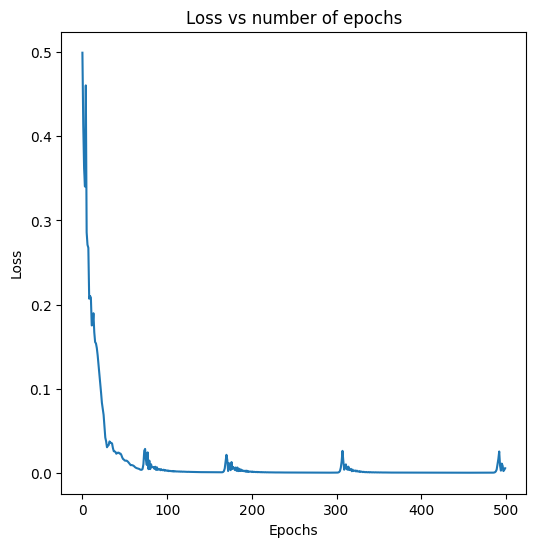

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(TOTAL_LOSS)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs number of epochs')

plt.savefig('Continuity_EpochLoss', dpi=300, bbox_inches='tight')


plt.show()

### 5. Testing the neural network.

In [ ]:
X_test = torch.linspace(0, 6, 50).view(-1, 1)
t_test = torch.linspace(0, 1, 50).view(-1, 1)

X_test, t_test = torch.meshgrid(X_test.squeeze(),  t_test.squeeze(), indexing='xy')

X_test = X_test.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

print(f"Shape of X_test : {X_test.shape} and t_test : {t_test.shape}")

Shape of X_test : torch.Size([2500, 1]) and t_test : torch.Size([2500, 1])


In [ ]:
model.eval()
with torch.no_grad():
  q_pred = model(X_test, t_test)

In [ ]:
q_pred = q_pred.numpy()
X_test = X_test.numpy()
t_test = t_test.numpy()

q_pred = q_pred.reshape(50, 50)
X_test = X_test.reshape(50, 50)
t_test = t_test.reshape(50, 50)

In [ ]:
print(f"Shape of q_pred, x_test, t_test is {q_pred.shape}, {X_test.shape}, and {t_test.shape}")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.contourf(X_test, t_test, q_pred, cmap='plasma', levels=250)
ax.set_xlabel('X (Space)')
ax.set_ylabel('T (Time)')
ax.set_zlabel('Q')

plt.savefig('Continuity_3D_Plot', dpi=300, bbox_inches='tight')

plt.show()